In [484]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import plotly.express as px
import missingno as msno
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cndbv13/test3.json
/kaggle/input/cndbv13/test1.json
/kaggle/input/cndbv13/test5.json
/kaggle/input/cndbv13/test2.json
/kaggle/input/cndbv13/test4.json


In [485]:
! head -n 2 /kaggle/input/cndbv13/test1.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{"_id":"53a7258520f7420be8b514a9","title":"Semantic Wikipedia.","authors":[{"_id":"53f47915dabfaefedbbb728f","name":"Max Völkel"},{"_id":"53f44a27dabfaedf435dbf2e","name":"Markus Krötzsch","orcid":"0000-0002-9172-2601"},{"_id":"5433f551dabfaebba5832602","name":"Denny Vrandecic"},{"_id":"53f322dddabfae9a84460560","name":"Heiko Haller"},{"_id":"53f556b9dabfaea7cd1d5e32","name":"Rudi Studer"}],"venue":{"_id":"53a7257a20f7420be8b50425","type":0,"raw":"WWW"},"year":2006,"n_citation":647,"page_start":"585","page_end":"594","lang":"en","volume":"","issue":"","issn":"","isbn":"","doi":"10.1145/1135777.1135863","pdf":null,"url":["http://doi.acm.org/10.1145/1135777.1135863","db

In [486]:
pip install pycairo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [487]:
# import bigjson
import json
from collections import defaultdict
from igraph import *
import igraph as ig
from cairo import *
import math
import matplotlib.pyplot as plt

In [488]:
all_keys = set()
count = 0
with open('/kaggle/input/cndbv13/test1.json', 'rb') as fin:
    for _ in range(100000):
        count += 1
        all_keys.update(json.loads(next(fin)))
print(sorted(all_keys))

['_id', 'abstract', 'authors', 'doi', 'fos', 'isbn', 'issn', 'issue', 'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 'references', 'title', 'url', 'venue', 'volume', 'year']


In [489]:
references_dict = defaultdict(list)

for path in [
    '/kaggle/input/cndbv13/test1.json',
    '/kaggle/input/cndbv13/test2.json',
    '/kaggle/input/cndbv13/test3.json',
    '/kaggle/input/cndbv13/test4.json',
    '/kaggle/input/cndbv13/test5.json'
]:
    with open(path, 'rb') as fin:
        cur_num = 0
        max_num = 10000
        line = next(fin)
        
        try:
            while line:
                cur_num += 1
                if cur_num == max_num:
                    break

                element = json.loads(line)
                line = next(fin)

                for reference in element.get('references', [np.nan]):
                    for key in ['_id', 'abstract', 'doi', 'fos', 'isbn', 'issn', 'issue', 
                                'keywords', 'lang', 'n_citation', 'page_end', 'page_start', 'pdf', 
                                'references', 'title','volume', 'year']:
                        references_dict[key].append(element.get(key, np.nan))

                    references_dict['url'].append(', '.join(element.get('url', [])))

                    authors = element.get('authors')
                    if authors is not None:
                        author_ids = '; '.join([x.get('_id', '') for x in authors if x is not None])
                        author_names = '; '.join([x.get('name', '') for x in authors if x is not None])
                    else:
                        author_ids = np.nan
                        author_names = np.nan
                    references_dict['author_ids'].append(author_ids)
                    references_dict['author_names'].append(author_names)

                    venue = element.get('venue')
                    if venue is not None:
                        venue_id = element['venue'].get('_id', np.nan)
                        venue_name = element['venue'].get('raw', np.nan)
                    else:
                        venue_id = np.nan
                        venue_name = np.nan
                    references_dict['venue_id'].append(venue_id)
                    references_dict['venue_name'].append(venue_name)
        
        except StopIteration as ex:
            pass

references_dict['id'] = references_dict.pop('_id')

In [490]:
data = pd.DataFrame.from_dict(references_dict)
data.head()

abstract                      doi  fos isbn issn issue keywords lang  \
0      NaN  10.1145/1135777.1135863  NaN                      NaN   en   
1      NaN                      NaN  NaN  NaN  NaN   NaN      NaN  NaN   
2      NaN                      NaN  NaN  NaN  NaN   NaN      NaN  NaN   
3      NaN                      NaN  NaN  NaN  NaN   NaN      NaN  NaN   
4      NaN                      NaN  NaN  NaN  NaN   NaN      NaN  NaN   

   n_citation page_end  ... references  \
0       647.0      594  ...        NaN   
1         NaN      NaN  ...        NaN   
2         NaN      NaN  ...        NaN   
3         NaN      NaN  ...        NaN   
4         NaN      NaN  ...        NaN   

                                               title volume    year  \
0                                Semantic Wikipedia.         2006.0   
1                   Deductive Algorithmic Knowledge.    NaN  2004.0   
2          Improving Exact Algorithms for MAX-2-SAT.    NaN  2004.0   
3                Learning via Finitely Many Queries.    NaN  2004.0   
4  A Framework for Sequential Planning in Multi-A...    NaN  2004.0   

                                                 url  \
0  http://doi.acm.org/10.1145/1135777.1135863, db...   
1  http://rutcor.rutgers.edu/~amai/aimath04/Accep...   
2  http://rutcor.rutgers.edu/~amai/aimath04/Accep...   
3  http://rutcor.rutgers.edu/~amai/aimath04/Accep...   
4  http://rutcor.rutgers.edu/~amai/aimath04/Accep...   

                                          author_ids  \
0  53f47915dabfaefedbbb728f; 53f44a27dabfaedf435d...   
1                                                      
2  53f4469bdabfaedd74def186; 54054904dabfae450f3a...   
3                                                      
4                         ; 5406cb05dabfae44f085c48f   

                                        author_names  \
0  Max Völkel; Markus Krötzsch; Denny Vrandecic; ...   
1                                   Riccardo Pucella   
2                           Haiou Shen; Hantao Zhang   
3                                      Andrew C. Lee   
4             Piotr J. Gmytrasiewicz; Prashant Doshi   

                   venue_id venue_name                        id  
0  53a7257a20f7420be8b50425        WWW  53a7258520f7420be8b514a9  
1  53a725d920f7420be8b5b577       AMAI  53a725db20f7420be8b5bfc6  
2  53a725d920f7420be8b5b577       AMAI  53a725db20f7420be8b5bff3  
3  53a725d920f7420be8b5b577       AMAI  53a725db20f7420be8b5bffb  
4  53a725d920f7420be8b5b577       AMAI  53a725db20f7420be8b5c00f  

[5 rows x 22 columns]

In [491]:
data.iloc[0, :]

abstract                                                      NaN
doi                                       10.1145/1135777.1135863
fos                                                           NaN
isbn                                                             
issn                                                             
issue                                                            
keywords                                                      NaN
lang                                                           en
n_citation                                                  647.0
page_end                                                      594
page_start                                                    585
pdf                                                          None
references                                                    NaN
title                                         Semantic Wikipedia.
volume                                                           
year      

In [492]:
data.iloc[0, ]

abstract                                                      NaN
doi                                       10.1145/1135777.1135863
fos                                                           NaN
isbn                                                             
issn                                                             
issue                                                            
keywords                                                      NaN
lang                                                           en
n_citation                                                  647.0
page_end                                                      594
page_start                                                    585
pdf                                                          None
references                                                    NaN
title                                         Semantic Wikipedia.
volume                                                           
year      

# Data gaps

In [493]:
data.shape, data.id.unique().shape # уникальных статей чуть меньше 50к

((372597, 22), (49995,))

In [494]:
data = data.loc[data.astype(str).drop_duplicates().index] # удаляем дубликаты

In [495]:
data.shape

(49995, 22)

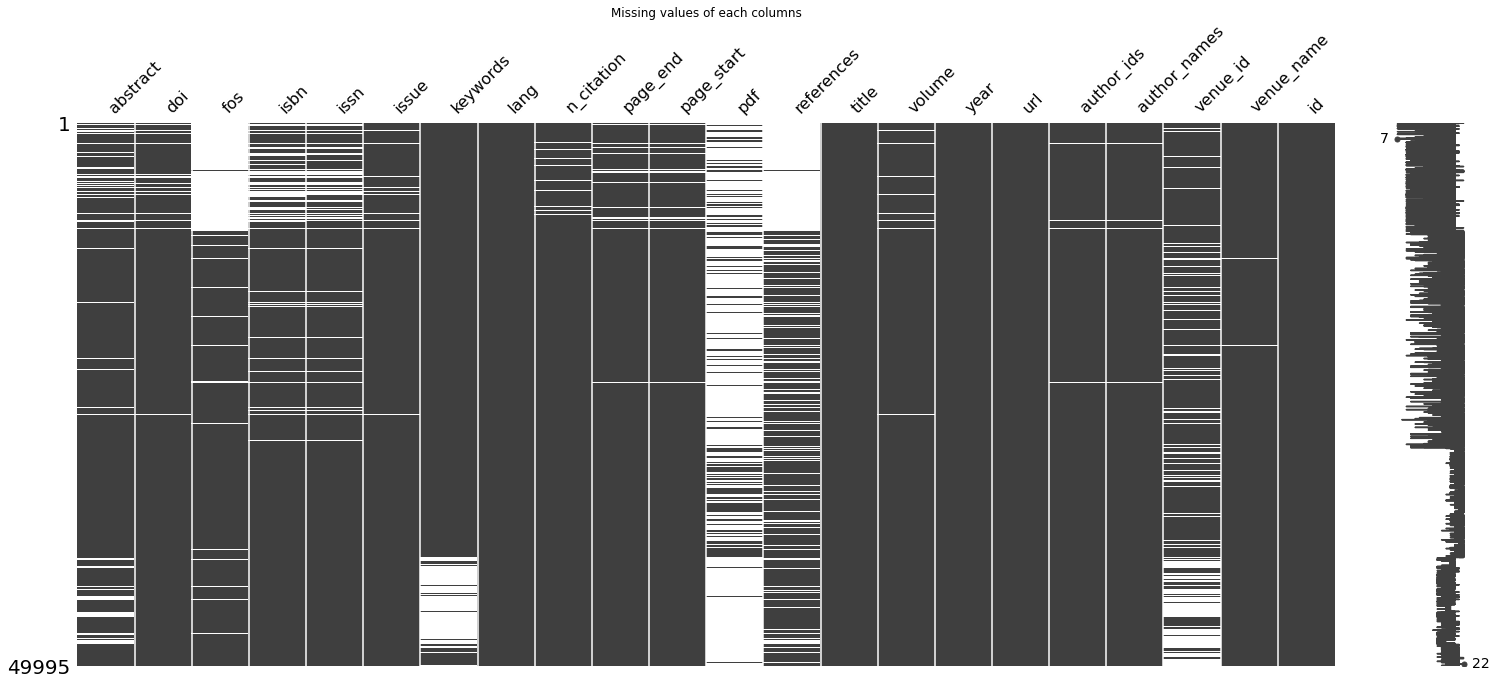

In [496]:
msno.matrix(data)
plt.title('Missing values of each columns');

# Language distribution

In [497]:
lang_data = data.lang[data.lang.notnull()]
lang_data.value_counts()

en    49958
zh        4
Name: lang, dtype: int64

In [498]:
lang_data.isnull().sum() # 0

0

In [499]:
keys, values = lang_data.value_counts().index, lang_data.value_counts().values

fig = px.bar(x=keys, y=values, color=keys,
             color_discrete_sequence=px.colors.sequential.Blues,
             title='Distribution of languages')

fig.update_layout(xaxis_title="language", yaxis_title="amount")

fig.data[0].marker.line.width = 1
fig.data[0].marker.line.color = "blue"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "crimson"

fig.show();

# Years distribution

In [500]:
years_data = data.year
years_data.value_counts().sort_values(ascending=False)

2017.0    9087
2013.0    6791
2011.0    4830
2010.0    2446
2009.0    2226
          ... 
1894.0       1
1927.0       1
1874.0       1
1929.0       1
1943.0       1
Name: year, Length: 114, dtype: int64

In [501]:
print(years_data.isnull().sum()) # 0

0


In [502]:
sorted(years_data.value_counts().index)[:10] # самые старые годы публикаций

[0.0, 13.0, 1874.0, 1894.0, 1898.0, 1901.0, 1903.0, 1905.0, 1907.0, 1911.0]

In [503]:
print(sorted(years_data.value_counts().index)[:2]) # минимальные значения year: [0.0, 13.0]
years_data[(years_data == 0) | (years_data == 13)].shape # 8 статей с (year =  0 или 13)

[0.0, 13.0]


(8,)

In [504]:
sorted(years_data.value_counts().index)[-10:] # топ 10

[2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0]

In [505]:
years_data = years_data.drop(years_data[(years_data == 0) | (years_data == 13)].index) # удаляем строчки с (year = 0 или 13)

In [506]:
sorted(years_data.value_counts().index)[:10] # топ 10

[1874.0,
 1894.0,
 1898.0,
 1901.0,
 1903.0,
 1905.0,
 1907.0,
 1911.0,
 1912.0,
 1916.0]

In [507]:
keys = list(map(lambda x: str(int(x)), years_data.value_counts().sort_values(ascending=False).index[:10]))
values = list(years_data.value_counts().sort_values(ascending=False).values[:10])

values.append(years_data.value_counts().sort_values(ascending=False).values[10:].sum())
keys.append('other') # весего уникальных значение в year 112, виден дисбаланс

fig = px.bar(x=keys, y=values, title = 'Rank of years', text_auto='.2s', labels={'x': 'year', 'y': 'number of articles'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)

fig.show();

In [508]:
years_data.value_counts()[years_data.value_counts() == 1].shape # 13 значений по 1 статье

(13,)

# Authors

In [509]:
data.author_names

0         Max Völkel; Markus Krötzsch; Denny Vrandecic; ...
1                                          Riccardo Pucella
2                                  Haiou Shen; Hantao Zhang
3                                             Andrew C. Lee
4                    Piotr J. Gmytrasiewicz; Prashant Doshi
                                ...                        
372561    Rhys Heffernan; Yuedong Yang; Kuldip K. Paliwa...
372580    Robert Kleffner; Jeff Flatten; Andrew Leaver-F...
372584    Nikolaos K. Chlis; F. Alexander Wolf; Fabian J...
372585    Feng Zeng; Zicheng Wang; Ying Wang; Jizhong Zh...
372593    Nicolas Städler; Frank Dondelinger; Steven M. ...
Name: author_names, Length: 49995, dtype: object

In [510]:
author_names = data.author_names
author_names.isnull().sum()

635

In [511]:
author_names.fillna('', inplace=True)

In [512]:
author_names.isnull().sum()

0

In [513]:
author_names[0]

'Max Völkel; Markus Krötzsch; Denny Vrandecic; Heiko Haller; Rudi Studer'

In [514]:
list(map(lambda x: x.strip(), data.author_names[0].split(';')))

['Max Völkel',
 'Markus Krötzsch',
 'Denny Vrandecic',
 'Heiko Haller',
 'Rudi Studer']

In [515]:
def preparation_func(string):
    '''Разделяем строку по ';' и убираем пробелы по краям у каждого автора'''
    return list(map(lambda x: x.strip(), string.split(';')))

In [516]:
author_names

0         Max Völkel; Markus Krötzsch; Denny Vrandecic; ...
1                                          Riccardo Pucella
2                                  Haiou Shen; Hantao Zhang
3                                             Andrew C. Lee
4                    Piotr J. Gmytrasiewicz; Prashant Doshi
                                ...                        
372561    Rhys Heffernan; Yuedong Yang; Kuldip K. Paliwa...
372580    Robert Kleffner; Jeff Flatten; Andrew Leaver-F...
372584    Nikolaos K. Chlis; F. Alexander Wolf; Fabian J...
372585    Feng Zeng; Zicheng Wang; Ying Wang; Jizhong Zh...
372593    Nicolas Städler; Frank Dondelinger; Steven M. ...
Name: author_names, Length: 49995, dtype: object

In [517]:
author_names = author_names.apply(lambda x: preparation_func(x))

In [518]:
author_names[0]

['Max Völkel',
 'Markus Krötzsch',
 'Denny Vrandecic',
 'Heiko Haller',
 'Rudi Studer']

In [519]:
data.author_names = author_names

In [520]:
authors = defaultdict(int)
for lst in author_names.values:
    for elem in lst:
        authors[elem] += 1 

In [521]:
authors[''] = 0

In [522]:
sorted(authors.values())[-10:]

[19, 19, 20, 21, 23, 23, 26, 27, 27, 72]

In [523]:
sorted(authors.keys())[-10:]

['İsmail Dinçer',
 'İsmail Yaslan',
 'Łukasz Kiedrowski',
 'Łukasz Matuszak',
 'Łukasz Sosnowski',
 'łukasz kaczmarczyk',
 'Şakir Şimşir',
 'Şebnem Düzgün',
 'Štefko Miklavič',
 '耕一 平田']

## Имена могут быть записаны по-разному, поэтому обратимся к id авторов

In [524]:
author_ids = data.author_ids
author_ids.isnull().sum()

635

In [525]:
author_ids = author_ids.fillna('')

In [526]:
author_ids = author_ids.apply(lambda x: preparation_func(x))

In [527]:
data.author_ids = author_ids
data.author_ids.head()

0    [53f47915dabfaefedbbb728f, 53f44a27dabfaedf435...
1                                                   []
2    [53f4469bdabfaedd74def186, 54054904dabfae450f3...
3                                                   []
4                         [, 5406cb05dabfae44f085c48f]
Name: author_ids, dtype: object

In [528]:
author_ids_dict = defaultdict(int)
for lst in author_ids.values:
    for elem in lst:
        author_ids_dict[elem] += 1 

In [529]:
keys = np.array(list(author_ids_dict.keys()))
keys[np.array(list(map(lambda x: len(x), keys))) < 5] # смотрим ключи длинной меньше 5

array([''], dtype='<U24')

In [530]:
author_ids_dict.pop('')

16868

In [531]:
len(author_ids_dict.values())

103108

In [532]:
sorted(author_ids_dict.values())[-10:] # топ 10 авторов по количеству статей

[13, 14, 14, 15, 15, 16, 20, 21, 27, 72]

In [533]:
(np.array(list((author_ids_dict.values()))) == 1).sum() # почти 90к авторов с 1 статьей

89749

In [534]:
counter = defaultdict(int)
for value in author_ids_dict.values():
    counter[value] += 1

In [535]:
keys, values = list(counter.keys()), list(counter.values())

fig = px.bar(x=keys, y=values, 
             title = 'Distribution of authors by number of articles', 
             width=1600, height=800, 
             labels={'x': 'number of articles', 'y': 'number of authors'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=2, opacity=0.7)

fig.show()

In [536]:
len(author_ids_dict) # всего авторов

103108

In [537]:
keys, values = list(range(1, 11)), sorted(author_ids_dict.values())[-10:]

fig = px.bar(x=keys, y=values, title = 'Top 10 authors by number of articles', text_auto='.2s', labels={'y': 'number of articles'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=2, opacity=0.7)

fig.show()

# Venue

In [538]:
data.venue_name.unique().shape, data.venue_id.unique().shape # второе значение - это количество уникальных журналов, статей, конференций и т.д.

((7304,), (6579,))

In [539]:
venue_ids = data.venue_id

In [540]:
venue_ids.value_counts()

55f957d4c35f4fb0d21ce0f1    385
5390796b20f770854f5b916d    374
53a72b0920f7420be8c16721    270
53a732db20f7420be8dba361    241
581304169ed5dbf6f8d2c460    228
                           ... 
555037bb7cea80f954197d69      1
53a7252220f7420be8b46a96      1
5390b76320f70186a0f22a06      1
53a72df020f7420be8c78b45      1
53a72e6520f7420be8c8bddd      1
Name: venue_id, Length: 6578, dtype: int64

In [541]:
names_of_venue = []
for id_ in venue_ids.value_counts().index:
    names_of_venue.append(data.venue_name[data.venue_id == id_].values[0])

In [542]:
names_of_venue[:20]

['Decision and Control',
 'Neural Computation',
 'INFOCOM',
 'Encyclopedia of Cryptography and Security (2nd Ed.)',
 'Multimedia Tools Appl.',
 'Bell System Technical Journal, The',
 'Geoscience and Remote Sensing Symposium',
 'Commun. ACM',
 'Datenschutz und Datensicherheit',
 'Scholarpedia',
 'ISCC',
 'Encyclopedia of Parallel Computing',
 'SIGGRAPH Electronic Art and Animation Catalog',
 'IJCNN',
 'ICASSP), 2002 IEEE International Conference',
 'Neural Computing and Applications',
 'Electronics, Circuits, and Systems',
 'INFOCOM Workshops',
 'Artificial Life',
 'Image Processing']

In [543]:
counter_venues = defaultdict(int)
for value in venue_ids.value_counts().values:
    counter_venues[value] += 1

In [544]:
keys, values = list(counter_venues.keys()), list(counter_venues.values())

fig = px.histogram(x=keys, y=values, 
             title = 'Distribution of authors by number of articles', 
             width=1600, height=800, 
             labels={'x': 'number of articles', 'y': 'number of authors'}, nbins=100, text_auto='.1s')

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  opacity=0.7)

fig.show()

In [545]:
len(names_of_venue), venue_ids.value_counts().shape

(6578, (6578,))

In [546]:
keys, values = names_of_venue[:10], venue_ids.value_counts().values[:10]

fig = px.bar(x=keys, y=values, title = 'Top venues by number of articles', text_auto='.3s', 
             labels={'x': 'name of venue', 'y': 'number of articles'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)

fig.show();

# Citations

In [547]:
n_citation = data.n_citation
n_citation.isnull().sum()

724

In [548]:
n_citation.head(10)

0    647.0
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7     41.0
8      NaN
9      NaN
Name: n_citation, dtype: float64

In [549]:
n_citation = n_citation.fillna(0)
data.n_citation = n_citation

In [550]:
n_citation.sort_values(ascending=False)

232747    77820.0
9828      26477.0
2331      21999.0
9125      19860.0
3382      14570.0
           ...   
10089         0.0
10091         0.0
2487          0.0
105268        0.0
134509        0.0
Name: n_citation, Length: 49995, dtype: float64

In [551]:
citation_counter = defaultdict(int)
for indx in data.index:
    for author_id in data.author_ids[indx]:
        citation_counter[author_id] += data.n_citation[indx]
citation_counter[''] = 0

In [552]:
sorted(list(citation_counter.items()), key=lambda x: -x[1])

[('563397ad45cedb339aaa7a43', 77820.0),
 ('53f45177dabfaee02ad45f0b', 26477.0),
 ('53f3264fdabfae9a844733ec', 25215.0),
 ('53f48458dabfaee4dc8b08e4', 25215.0),
 ('53f42d00dabfaee0d9af752c', 25111.0),
 ('53f4b95bdabfaed84077b41f', 19860.0),
 ('53f46acadabfaedf436572f2', 16449.0),
 ('53f45a73dabfaedd74e3d683', 14570.0),
 ('53f4d370dabfaef206f80e73', 14570.0),
 ('53f4488cdabfaedce558015c', 13133.0),
 ('53f37c22dabfae4b349e60a1', 9868.0),
 ('53f79676dabfae8faa49c864', 9361.0),
 ('53f44a18dabfaee4dc7e0280', 9127.0),
 ('53f459fadabfaedf43619148', 8870.0),
 ('54486e57dabfae87b7e21fae', 8861.0),
 ('53f4543cdabfaee0d9beb922', 8834.0),
 ('54898b46dabfaed7b5fa3cf3', 8834.0),
 ('53f431a4dabfaee43ebfbed1', 8826.0),
 ('53f42b78dabfaedce54a70c4', 8826.0),
 ('53f42c7ddabfaec22ba0a121', 8826.0),
 ('5631094445cedb3399c5c0f2', 8800.0),
 ('5631094445cedb3399c5c0f6', 8800.0),
 ('5631094545cedb3399c5c0fa', 8800.0),
 ('53f44e0edabfaedd74e0d1ed', 8742.0),
 ('53f43158dabfaee4dc74bd3b', 8705.0),
 ('5631057045ce

In [553]:
sorted(list(citation_counter.values()), reverse=True)[:10]

[77820.0,
 26477.0,
 25215.0,
 25215.0,
 25111.0,
 19860.0,
 16449.0,
 14570.0,
 14570.0,
 13133.0]

In [554]:
keys, values = range(10), sorted(list(citation_counter.values()), reverse=True)[:10]

fig = px.bar(x=keys, y=values, 
                  title = 'Distribution of authors by number of citations', 
                  text_auto='.4s',
                  labels={'y': 'number of citations'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=2, opacity=0.7)

fig.show()

In [555]:
data.author_names[n_citation.sort_values(ascending=False).index[:10]]

232747                                  [Claude E. Shannon]
9828                                         [D. L. Donoho]
2331                                           [W S BRINES]
9125                                          [Leo Breiman]
3382                       [C. de L. Ryals, K. J. Fielding]
7373                                          [John Cullen]
117794    [Garrett M. Morris, David S. Goodsell, Robert ...
240071      [Sch&#246, lkopf, B, Smola, A, M&#252, ller, K]
559       [Dennis A. Benson, Mark S. Boguski, David J. L...
230362                                [Foschini, Gerard J.]
Name: author_names, dtype: object

In [556]:
keys, values = range(10), n_citation.sort_values(ascending=False).values[:10]

fig = px.bar(x=keys, y=values, title = 'Top 10 articles by number of citations', 
             text_auto='.2s',
             labels={'y': 'number of citations'})

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)

fig.show();

# Word Cloud

In [557]:
data_abstract = data.abstract[data.abstract.isnull() == False]

In [558]:
# comment_words = ''
# stopwords = set(STOPWORDS)


# for val in tqdm(data_abstract):
#     val = str(val)
#     tokens = val.split()
     
#     for i in range(len(tokens)):
#         tokens[i] = tokens[i].lower()
     
#     comment_words += " ".join(tokens)+" "

In [559]:
# wordcloud = WordCloud(width = 800, height = 800,
#                      background_color ='black',
#                      stopwords = stopwords,
#                      min_font_size = 10).generate(comment_words)
# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad = 0)
 
# plt.show()

In [560]:
# data_abstract.iloc

In [561]:
# comment_words = ''
# stopwords = set(STOPWORDS)
# data_fos = data.fos[data.fos.isnull() != True].apply(lambda x: map(lambda v: str(v), x).split(','))

# for val in tqdm(data_fos[:200]):
#     val = str(val)
#     tokens = val.split()
     
#     for i in range(len(tokens)):
#         tokens[i] = tokens[i].lower()
     
#     comment_words += " ".join(tokens)+" "
    
# wordcloud = WordCloud(width = 800, height = 500,
#                  background_color ='black',
#                  stopwords = stopwords,
#                  min_font_size = 10).generate(comment_words)
# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad = 0)
 
# plt.show()

In [562]:
# data.fos[data.fos.isnull() != True]

# Texts preprocessing

In [563]:
data_en = data[data.lang == 'en']
data[data.lang == 'en'].shape

data_en = data_en[data_en.abstract.isnull() == False]

In [564]:
data_en.shape

(44985, 22)

In [565]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm

def preprocess_text(texts):
    stop_words = set(stopwords.words("english"))
    regex = re.compile("[^a-z A-Z]")
    preprocess_texts = []
    for i in tqdm(range(len(texts))):
        text = texts[i].lower()
        text = regex.sub(' ', text)
        word_tokens = word_tokenize(text)
        filtered_sentence = [word for word in word_tokens if word not in stop_words]
        preprocess_texts.append(' '.join(filtered_sentence))
    return preprocess_texts

In [566]:
data_en.abstract = preprocess_text(list(data_en.abstract))

  0%|          | 0/44985 [00:00<?, ?it/s]

In [567]:
data_en.abstract.iloc[0]

'drought first place natural disasters world especially serious north china plain paper different soil water content control levels winter wheat growth stages performed gucheng ecological meteorological integrated observation experiment station cams china canopy parameters including growth conditions dry weight physiological parameters hyperspectral reflectance measured erecting stage milk stage winter wheat relationship canopy parameters soil relative moisture canopy water content water indices winter wheat established results show parameters spad dry weight leaves decrease increasing soil relative moisture parameters including dry weight caudexes ground dry weight height photosynthesis rate intercellular co concentration stomatal conductance transpiration rate increase corresponding soil relative moisture obvious linear relationship stomatal conductance transpiration rate established samples r reaches finally fitting equations canopy water content water indices regressed b b b modis 

In [568]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
def lemmatization_texts(texts):
    lmt = WordNetLemmatizer()
    lmt_texts = []
    for text in tqdm(texts):
        word_tokens = word_tokenize(text)
        lmt_texts.append(' '.join([lmt.lemmatize(word) for word in word_tokens]))
    return lmt_texts

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [569]:
data_en.abstract = lemmatization_texts(list(data_en.abstract))

  0%|          | 0/44985 [00:00<?, ?it/s]

In [570]:
data_en.abstract.iloc[0]

'drought first place natural disaster world especially serious north china plain paper different soil water content control level winter wheat growth stage performed gucheng ecological meteorological integrated observation experiment station cam china canopy parameter including growth condition dry weight physiological parameter hyperspectral reflectance measured erecting stage milk stage winter wheat relationship canopy parameter soil relative moisture canopy water content water index winter wheat established result show parameter spad dry weight leaf decrease increasing soil relative moisture parameter including dry weight caudex ground dry weight height photosynthesis rate intercellular co concentration stomatal conductance transpiration rate increase corresponding soil relative moisture obvious linear relationship stomatal conductance transpiration rate established sample r reach finally fitting equation canopy water content water index regressed b b b modis band equation best b wo

# Classifier

In [571]:
# data_en.shape

In [572]:
# data_en.fos.isnull().sum(), data_en.keywords.isnull().sum()

In [573]:
# data_en = data_en[(data_en.fos.notnull()) & (data_en.abstract != '')]

In [574]:
# data_en.shape

In [575]:
# def make_new_fos(data_en, treshold=50):
#     all_fos = []
#     for elem in data_en.fos:
#         all_fos.extend(elem)
#     short_fos = np.array(list(filter(lambda x: x[1] >= treshold, Counter(all_fos).most_common())))[:, 0]
#     new_fos = data_en.fos.apply(lambda x: [elem for elem in x if elem in short_fos])
#     return new_fos, short_fos

In [576]:
# new_fos, short_fos = make_new_fos(data_en)

In [577]:
# new_fos.shape, data_en.shape

In [578]:
# dct_fos = dict(zip(range(len(short_fos)), short_fos))

In [579]:
# ohe_new_fos = [[0] * len(dct_fos) for elem in new_fos]

In [580]:
# for first_indx, lst in enumerate(ohe_new_fos):
#     for indx in range(len(lst)):
#         lst[indx] = 1 if dct_fos[indx] in new_fos.iloc[first_indx] else 0

In [581]:
# len(ohe_new_fos)

In [582]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer_tf_idf = TfidfVectorizer()
# vectorizer_tf_idf.fit(data_en.abstract)
# tf_idf = vectorizer_tf_idf.transform(data_en.abstract)

In [583]:
# X_train, y_train = tf_idf[:10000].toarray(), np.array(ohe_new_fos[:10000])
# X_test, y_test = tf_idf[10000:13000].toarray(), np.array(ohe_new_fos[10000:13000])

In [584]:
# from imblearn.over_sampling import SMOTE
# from catboost import CatBoostClassifier
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# def fit(X_train, y_train):
#     lst_log_reg = [QuadraticDiscriminantAnalysis() for _ in range(len(y_train[0]))]
#     for i in tqdm(range(len(lst_log_reg))):
#         sm = SMOTE(k_neighbors=3)
#         try:
#             X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train[:, i])
#             lst_log_reg[i].fit(X_train_smote, y_train_smote)
#         except ValueError:
#             lst_log_reg[i] = None
#     return lst_log_reg

In [585]:
# lst_log_reg = fit(X_train, y_train)

In [586]:
# from heapq import nlargest

# def predict(lst_log_reg, X_test, n_labels=3, dct_fos=dct_fos):
#     prediction = []
#     for item in tqdm(X_test):
#         lst = []
#         for lr in lst_log_reg:
#             try:
#                 lst.append(lr.predict_proba(item)[:, 1])
#             except:
#                 lst.append(0)
#         the_biggest = nlargest(5, lst)
#         prediction.append([dct_fos[lst.index(elem)] for elem in the_biggest])
#     return prediction

In [587]:
# prediction = predict(lst_log_reg, X_test)

In [588]:
# prediction[32]

In [589]:
# new_fos.iloc[32]

In [590]:
# from sklearn.metrics import average_precision_score
# print(average_precision_score(y_test, prediction))

# Topic modelling

In [591]:
# данные с заполенными аннотациями
data_not_empty_abstract = data_en[data_en.abstract != ''].abstract

In [592]:
data_not_empty_abstract.shape, data_en.shape

((37249,), (44985, 22))

In [593]:
!pip install bertopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [594]:
# ссылка на доку
# https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.__init__
from bertopic import BERTopic


# можно еще добавлять n-граммы, но в таком случае у меня падает ноутбук из-за memory limit при визуализации
# колчество кластеров и размер "шумового" при этом особо не меняются. проверял до 4-х включительно
model = BERTopic(language="english",
                 verbose=True)
topics, probs = model.fit_transform(data_not_empty_abstract.values)

Batches:   0%|          | 0/1165 [00:00<?, ?it/s]

2022-10-27 13:54:54,002 - BERTopic - Transformed documents to Embeddings
2022-10-27 13:55:25,718 - BERTopic - Reduced dimensionality
2022-10-27 13:55:27,795 - BERTopic - Clustered reduced embeddings


In [595]:
freq = model.get_topic_info(); freq.head(10)
# -1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated

Topic  Count                                     Name
0     -1  15403             -1_system_paper_model_design
1      0    865                0_gene_protein_genome_dna
2      1    539        1_student_learning_course_teacher
3      2    537           2_logic_calculus_proof_algebra
4      3    378              3_graph_vertex_edge_digraph
5      4    373                4_sensor_node_wsns_energy
6      5    322         5_vehicle_traffic_driver_driving
7      6    318  6_speech_speaker_microphone_recognition
8      7    300           7_patient_health_care_clinical
9      8    296      8_hyperspectral_land_spectral_lidar

In [596]:
# всего тем
freq.shape 

(410, 3)

In [597]:
model.visualize_topics()

### We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [598]:
model.visualize_barchart(top_n_topics=5)

### Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [599]:
model.visualize_heatmap(n_clusters=25, width=1000, height=1000)

### After having trained our model, we can use find_topics to search for topics that are similar to an input search_term. Here, we are going to be searching for topics that closely relate the search term "vehicle". Then, we extract the most similar topic and check the results: 

In [600]:
similar_topics, similarity = model.find_topics("nlp", top_n=5); similar_topics

[11, 169, 135, 322, 218]

In [601]:
model.get_topic(similar_topics[0])

[('word', 0.02725477864553772),
 ('corpus', 0.019733290535773867),
 ('translation', 0.018553842650947047),
 ('sentence', 0.015246942415876494),
 ('text', 0.014032233716399296),
 ('semantic', 0.014028259633692811),
 ('english', 0.013525847676040667),
 ('syntactic', 0.01302772529873921),
 ('language', 0.012419700209525417),
 ('lexical', 0.01106728574067792)]

In [602]:
# topic_model.save("my_model")
# my_model = BERTopic.load("my_model")